In [4]:
!pip install --quiet --upgrade transformers
!pip install --quiet huggingface_hub[hf_xet]

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.amp import autocast, GradScaler
from transformers import DistilBertTokenizer, DistilBertModel, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
import warnings

In [ ]:
warnings.filterwarnings("ignore", message="Unable to register cuFFT factory")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")
RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)
DEVICE = torch.device("cuda")
torch.backends.cudnn.benchmark = True

In [ ]:
def LoadPubmedRctFile(FilePath):
    Cases = []
    with open(FilePath, "r", encoding="utf-8") as Fobj:
        Case = {"label": None, "text": ""}
        for Line in Fobj:
            Line = Line.strip()
            if Line == "":
                if Case["label"] and Case["text"]:
                    Cases.append(Case)
                Case = {"label": None, "text": ""}
            elif Line.split("\t")[0].isupper():
                if Case["label"] and Case["text"]:
                    Cases.append(Case)
                Parts = Line.split("\t")
                Case = {"label": Parts[0], "text": Parts[1]}
            else:
                Case["text"] += " " + Line.strip()
        if Case["label"] and Case["text"]:
            Cases.append(Case)
    DF = pd.DataFrame(Cases)
    print(f"Dataset loaded with {len(DF)} samples.")
    print(DF.head())
    return DF

In [ ]:
class LoadPubmedRct:
    def __init__(self, FilePath):
        self.DataFrame = LoadPubmedRctFile(FilePath)
    def GetDataFrame(self):
        return self.DataFrame

In [ ]:
class SplitTrainTestVal:
    def __init__(self, DataFrame):
        self.DataFrame = DataFrame
    def Split(self):
        TrainData, TempData = train_test_split(
            self.DataFrame,
            test_size=0.2,
            stratify=self.DataFrame["label"],
            random_state=RandomState
        )
        ValData, TestData = train_test_split(
            TempData,
            test_size=0.5,
            stratify=TempData["label"],
            random_state=RandomState
        )
        print("Train:", len(TrainData), "Val:", len(ValData), "Test:", len(TestData))
        return TrainData, ValData, TestData

In [ ]:
class AugSynonymReplace:
    def __init__(self, Probability=0.15):
        self.Probability = Probability
    def __call__(self, Text):
        Words = Text.split()
        NewWords = []
        for W in Words:
            if random.random() < self.Probability:
                Syns = wordnet.synsets(W)
                if Syns:
                    Lemmas = Syns[0].lemmas()
                    if Lemmas:
                        Synonym = Lemmas[0].name()
                        if Synonym != W:
                            NewWords.append(Synonym)
                            continue
            NewWords.append(W)
        return " ".join(NewWords)

class AugRandomMask:
    def __init__(self, Tokenizer):
        self.Tokenizer = Tokenizer
    def __call__(self, Text):
        Tokens = self.Tokenizer.tokenize(Text)
        if len(Tokens) == 0:
            return Text
        Idx = random.randint(0, len(Tokens)-1)
        Tokens[Idx] = self.Tokenizer.mask_token
        return self.Tokenizer.convert_tokens_to_string(Tokens)

class AugRandomDelete:
    def __init__(self, Probability=0.15):
        self.Probability = Probability
    def __call__(self, Text):
        Words = Text.split()
        NewWords = []
        for W in Words:
            if random.random() < self.Probability:
                continue
            NewWords.append(W)
        return " ".join(NewWords)

class AugRandomSwap:
    def __init__(self, Probability=0.15):
        self.Probability = Probability
    def __call__(self, Text):
        Words = Text.split()
        if len(Words) < 2:
            return Text
        if random.random() < self.Probability:
            i = random.randint(0, len(Words)-1)
            j = random.randint(0, len(Words)-1)
            while j == i:
                j = random.randint(0, len(Words)-1)
            Words[i], Words[j] = Words[j], Words[i]
        return " ".join(Words)

In [ ]:
class WeakAugmentText:
    def __init__(self, Tokenizer):
        self.Tokenizer = Tokenizer
        self.SynReplace = AugSynonymReplace(Probability=0.1)
        self.Mask = AugRandomMask(Tokenizer)
    def __call__(self, Text):
        SynText = self.SynReplace(Text)
        MaskedText = self.Mask(SynText)
        return MaskedText

class StrongAugmentText:
    def __init__(self, Tokenizer):
        self.Tokenizer = Tokenizer
        self.SynReplace = AugSynonymReplace(Probability=0.2)
        self.Delete = AugRandomDelete(Probability=0.15)
        self.Swap = AugRandomSwap(Probability=0.15)
    def __call__(self, Text):
        SynText = self.SynReplace(Text)
        DeletedText = self.Delete(SynText)
        SwappedText = self.Swap(DeletedText)
        return SwappedText

In [ ]:
class PubmedRctReFixMatchDataset(Dataset):
    def __init__(self, DataFrame, Tokenizer, MaxLen=128, IsUnlabeled=False):
        super().__init__()
        self.Df = DataFrame.reset_index(drop=True)
        self.Tokenizer = Tokenizer
        self.MaxLen = MaxLen
        self.IsUnlabeled = IsUnlabeled
        self.LabelList = sorted(self.Df["label"].unique())
        self.Label2Idx = {Lab: i for i, Lab in enumerate(self.LabelList)}
        self.WeakAug = WeakAugmentText(Tokenizer)
        self.StrongAug = StrongAugmentText(Tokenizer)
    def __len__(self):
        return len(self.Df)
    def __getitem__(self, Idx):
        Row = self.Df.iloc[Idx]
        Text = Row["text"]
        LabelStr = Row["label"]
        Label = self.Label2Idx[LabelStr]
        OriginalEnc = self.Tokenizer.encode_plus(
            Text,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )
        WeakText = self.WeakAug(Text)
        WeakEnc = self.Tokenizer.encode_plus(
            WeakText,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )
        StrongText = self.StrongAug(Text)
        StrongEnc = self.Tokenizer.encode_plus(
            StrongText,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )
        if self.IsUnlabeled:
            Label = -1
        return {
            "OriginalInputIds": OriginalEnc["input_ids"].squeeze(0),
            "OriginalAttentionMask": OriginalEnc["attention_mask"].squeeze(0),
            "WeakInputIds": WeakEnc["input_ids"].squeeze(0),
            "WeakAttentionMask": WeakEnc["attention_mask"].squeeze(0),
            "StrongInputIds": StrongEnc["input_ids"].squeeze(0),
            "StrongAttentionMask": StrongEnc["attention_mask"].squeeze(0),
            "Label": Label
        }

In [ ]:
class PubmedRctTestDataset(Dataset):
    def __init__(self, DataFrame, Tokenizer, MaxLen=128):
        super().__init__()
        self.Df = DataFrame.reset_index(drop=True)
        self.Tokenizer = Tokenizer
        self.MaxLen = MaxLen
        self.LabelList = sorted(self.Df["label"].unique())
        self.Label2Idx = {Lab: i for i, Lab in enumerate(self.LabelList)}
    def __len__(self):
        return len(self.Df)
    def __getitem__(self, Idx):
        Row = self.Df.iloc[Idx]
        Text = Row["text"]
        LabelStr = Row["label"]
        Label = self.Label2Idx[LabelStr]
        Enc = self.Tokenizer.encode_plus(
            Text,
            truncation=True,
            max_length=self.MaxLen,
            return_tensors="pt",
            padding="max_length"
        )
        return {
            "InputIds": Enc["input_ids"].squeeze(0),
            "AttentionMask": Enc["attention_mask"].squeeze(0),
            "Label": Label
        }

In [ ]:
class DistilBertReFixMatch(nn.Module):
    def __init__(self, NumLabels):
        super().__init__()
        self.Model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        HiddenSize = self.Model.config.dim
        self.Classifier = nn.Linear(HiddenSize, NumLabels)
    def forward(self, InputIds, AttentionMask):
        Out = self.Model(InputIds, attention_mask=AttentionMask)
        HiddenState = Out.last_hidden_state[:, 0]
        Logits = self.Classifier(HiddenState)
        return Logits

In [ ]:
class TrainReFixMatchText:
    def __init__(
        self,
        Model,
        LabeledLoader,
        UnlabeledLoader,
        ValLoader,
        TestLoader,
        LabelList,
        Epochs=3,
        Lr=2e-5,
        Tau=0.95,
        LambdaU=0.8,
        Device=DEVICE,
        Eps=1e-8,
        RunName="Run"
    ):
        self.Model = Model.to(Device)
        self.LabeledLoader = LabeledLoader
        self.UnlabeledLoader = UnlabeledLoader
        self.ValLoader = ValLoader
        self.TestLoader = TestLoader
        self.LabelList = LabelList
        self.NumLabels = len(LabelList)
        self.Epochs = Epochs
        self.Lr = Lr
        self.Tau = Tau
        self.LambdaU = LambdaU
        self.Device = Device
        self.Eps = Eps
        self.RunName = RunName
    def Run(self):
        Optimizer = optim.AdamW(self.Model.parameters(), lr=self.Lr)
        TotalSteps = self.Epochs * len(self.LabeledLoader)
        Scheduler = get_cosine_schedule_with_warmup(
            Optimizer, num_warmup_steps=0, num_training_steps=TotalSteps
        )
        scaler = GradScaler()
        TrainLossList = []
        TrainSupLossList = []
        TrainUnsupLossList = []
        TrainAccList = []
        ValLossList = []
        ValAccList = []
        for Ep in range(self.Epochs):
            self.Model.train()
            TotalLoss = 0.0
            SupLossTotal = 0.0
            UnsupLossTotal = 0.0
            CorrectSup = 0
            TotalSup = 0
            NumBatches = 0
            UnlabeledIter = iter(self.UnlabeledLoader)
            for LabeledBatch in tqdm(self.LabeledLoader, desc=f"{self.RunName} E{Ep+1}/{self.Epochs}", leave=False):
                InputsWeakIds = LabeledBatch["WeakInputIds"].to(self.Device)
                InputsWeakMask = LabeledBatch["WeakAttentionMask"].to(self.Device)
                LabelsL = LabeledBatch["Label"].to(self.Device)
                with autocast(device_type="cuda"):
                    LogitsL = self.Model(InputsWeakIds, InputsWeakMask)
                    LossSup = F.cross_entropy(LogitsL, LabelsL)
                PredsL = torch.argmax(LogitsL, dim=1)
                CorrectSup += (PredsL == LabelsL).sum().item()
                TotalSup += LabelsL.size(0)
                try:
                    UnlabeledBatch = next(UnlabeledIter)
                except StopIteration:
                    UnlabeledIter = iter(self.UnlabeledLoader)
                    UnlabeledBatch = next(UnlabeledIter)
                UWeakIds = UnlabeledBatch["WeakInputIds"].to(self.Device)
                UWeakMask = UnlabeledBatch["WeakAttentionMask"].to(self.Device)
                UStrongIds = UnlabeledBatch["StrongInputIds"].to(self.Device)
                UStrongMask = UnlabeledBatch["StrongAttentionMask"].to(self.Device)
                with torch.no_grad():
                    with autocast(device_type="cuda"):
                        LogitsUWeak = self.Model(UWeakIds, UWeakMask)
                        ProbsUWeak = F.softmax(LogitsUWeak, dim=1)
                MaxProbs, PseudoLabels = torch.max(ProbsUWeak, dim=1)
                Mask = (MaxProbs >= self.Tau).float()
                with autocast(device_type="cuda"):
                    LogitsUStrong = self.Model(UStrongIds, UStrongMask)
                    ProbsUStrong = F.softmax(LogitsUStrong, dim=1)
                    LossUCE = F.cross_entropy(LogitsUStrong, PseudoLabels, reduction="none")
                    LossUCE = (LossUCE * Mask).mean()
                LowConfMask = 1 - Mask
                if LowConfMask.sum() > 0:
                    Temp = 0.5
                    PUWeakSharp = ProbsUWeak ** (1.0 / Temp)
                    PUWeakSharp = PUWeakSharp / (PUWeakSharp.sum(dim=1, keepdim=True) + self.Eps)
                    with autocast(device_type="cuda"):
                        LossUKL = F.kl_div(
                            torch.log(torch.clamp(PUWeakSharp, min=self.Eps)),
                            ProbsUStrong,
                            reduction="batchmean"
                        )
                else:
                    LossUKL = 0.0
                LossUnsup = LossUCE + (LossUKL if not isinstance(LossUKL, float) else 0.0)
                Loss = LossSup + self.LambdaU * LossUnsup
                Optimizer.zero_grad()
                scaler.scale(Loss).backward()
                torch.nn.utils.clip_grad_norm_(self.Model.parameters(), 1.0)

                scaler.step(Optimizer)
                scaler.update()
                Scheduler.step()
                TotalLoss += Loss.item()
                SupLossTotal += LossSup.item()
                UnsupLossTotal += LossUnsup.item()
                NumBatches += 1
            AvgLoss = TotalLoss / NumBatches
            AvgSupLoss = SupLossTotal / NumBatches
            AvgUnsupLoss = UnsupLossTotal / NumBatches
            TrainAcc = CorrectSup / TotalSup
            TrainLossList.append(AvgLoss)
            TrainSupLossList.append(AvgSupLoss)
            TrainUnsupLossList.append(AvgUnsupLoss)
            TrainAccList.append(TrainAcc)
            self.Model.eval()
            ValLossVal = 0.0
            ValBatches = 0
            ValPreds = []
            ValLabelsList = []
            with torch.no_grad():
                for Batch in self.ValLoader:
                    Ids_ = Batch["InputIds"].to(self.Device)
                    Mask_ = Batch["AttentionMask"].to(self.Device)
                    Labels_ = Batch["Label"].to(self.Device)
                    with autocast(device_type="cuda"):
                        Logits_ = self.Model(Ids_, Mask_)
                        Loss_ = F.cross_entropy(Logits_, Labels_)
                    ValLossVal += Loss_.item()
                    ValBatches += 1
                    Preds_ = torch.argmax(Logits_, dim=1)
                    ValPreds.extend(Preds_.cpu().numpy())
                    ValLabelsList.extend(Labels_.cpu().numpy())
            AvgValLoss = ValLossVal / ValBatches
            ValAccuracy = accuracy_score(ValLabelsList, ValPreds)
            ValLossList.append(AvgValLoss)
            ValAccList.append(ValAccuracy)
            print(f"{self.RunName} Epoch[{Ep+1}/{self.Epochs}] "
                  f"TrainLoss: {AvgLoss:.4f} (Sup={AvgSupLoss:.4f}, Unsup={AvgUnsupLoss:.4f}) "
                  f"TrainAcc: {TrainAcc*100:.2f}% "
                  f"ValLoss: {AvgValLoss:.4f} ValAcc: {ValAccuracy*100:.2f}%")

        TestPreds = []
        TestLabelsList = []
        TestProbsList = []
        self.Model.eval()
        with torch.no_grad():
            for Batch in self.TestLoader:
                Ids_ = Batch["InputIds"].to(self.Device)
                Mask_ = Batch["AttentionMask"].to(self.Device)
                Labels_ = Batch["Label"].to(self.Device)
                with autocast(device_type="cuda"):
                    Logits_ = self.Model(Ids_, Mask_)
                    Probs_ = F.softmax(Logits_, dim=1)
                Preds_ = torch.argmax(Logits_, dim=1)
                TestPreds.extend(Preds_.cpu().numpy())
                TestLabelsList.extend(Labels_.cpu().numpy())
                TestProbsList.extend(Probs_.cpu().numpy())
        TestAcc = accuracy_score(TestLabelsList, TestPreds)
        OneHotLabels = np.eye(self.NumLabels)[np.array(TestLabelsList)]
        RocAuc = roc_auc_score(OneHotLabels, np.array(TestProbsList), multi_class="ovr")
        AvgPrecision = average_precision_score(OneHotLabels, np.array(TestProbsList), average="macro")
        print(f"\n{self.RunName} Final Test Results:")
        print(f"Test Accuracy: {TestAcc*100:.2f}%")
        print(f"ROC AUC: {RocAuc:.4f}, Average Precision: {AvgPrecision:.4f}")
        print("Classification Report:")
        print(classification_report(TestLabelsList, TestPreds, target_names=self.LabelList, zero_division=0))
        return {
            "TrainLoss": TrainLossList,
            "TrainSupLoss": TrainSupLossList,
            "TrainUnsupLoss": TrainUnsupLossList,
            "TrainAcc": TrainAccList,
            "ValLoss": ValLossList,
            "ValAcc": ValAccList,
            "TestAcc": TestAcc,
            "RocAuc": RocAuc,
            "AvgPrecision": AvgPrecision
        }

In [ ]:
def Main():
    nltk.download("wordnet")
    FilePath = r"/kaggle/input/pubmed-rct/pubmed_rct.txt"
    Loader = LoadPubmedRct(FilePath)
    DF = Loader.GetDataFrame()
    Splitter = SplitTrainTestVal(DF)
    TrainDF, ValDF, TestDF = Splitter.Split()
    LabelList = sorted(DF["label"].unique())
    Tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    ValData = PubmedRctTestDataset(ValDF, Tokenizer, MaxLen=256)
    TestData = PubmedRctTestDataset(TestDF, Tokenizer, MaxLen=256)
    ValLoader = DataLoader(ValData, batch_size=4, shuffle=False)
    TestLoader = DataLoader(TestData, batch_size=4, shuffle=False)
    LabeledSizes = [20000, 40000, 80000, 120000]
    ResultsDict = {}
    for Size in LabeledSizes:
        print(f"\nRunning ReFixMatch With {Size} Labeled Samples Training Samples")
        Fraction = Size / len(TrainDF)
        LabeledSplit, UnlabeledSplit = train_test_split(
            TrainDF,
            train_size=Fraction,
            stratify=TrainDF["label"],
            random_state=RandomState
        )
        LabeledDataset = PubmedRctReFixMatchDataset(
            LabeledSplit, Tokenizer, MaxLen=256, IsUnlabeled=False
        )
        UnlabeledDataset = PubmedRctReFixMatchDataset(
            UnlabeledSplit, Tokenizer, MaxLen=256, IsUnlabeled=True
        )
        LabeledLoader = DataLoader(LabeledDataset, batch_size=4, shuffle=True)
        UnlabeledLoader = DataLoader(UnlabeledDataset, batch_size=4, shuffle=True)
        Model = DistilBertReFixMatch(NumLabels=len(LabelList))
        Trainer = TrainReFixMatchText(
            Model,
            LabeledLoader,
            UnlabeledLoader,
            ValLoader,
            TestLoader,
            LabelList,
            Epochs=3,
            Lr=2e-5,
            Tau=0.95,
            LambdaU=0.8,
            Device=DEVICE,
            RunName=f"PubMedRCT_{Size}_Labeled"
        )
        RunResults = Trainer.Run()

        torch.save(Model.state_dict(), f"ReFixMatch_PubMed_RCT_{Size}_labeled.pth")
        print(f"Model weights saved to model_weights_{Size}_labeled.pth")
        EpochsRange = range(1, len(RunResults["TrainLoss"]) + 1)
        plt.figure(figsize=(8,5))
        plt.plot(EpochsRange, RunResults["TrainLoss"], label="Total Train Loss", marker="o")
        plt.plot(EpochsRange, RunResults["TrainSupLoss"], label="Supervised Loss", marker="o")
        plt.plot(EpochsRange, RunResults["TrainUnsupLoss"], label="Unsupervised Loss", marker="o")
        plt.title(f"Training Loss Curves ({Size} Labeled)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(8,5))
        plt.plot(EpochsRange, RunResults["TrainAcc"], label="Train Accuracy", marker="o")
        plt.title(f"Training Accuracy (FC={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(8,5))
        plt.plot(EpochsRange, RunResults["ValLoss"], label="Validation Loss", marker="o")
        plt.title(f"Validation Loss (FC={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(8,5))
        plt.plot(EpochsRange, [v * 100 for v in RunResults["ValAcc"]], label="Val Accuracy (%)", marker="o")
        plt.title(f"Validation Accuracy (FC={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(8,5))
        plt.plot(EpochsRange, RunResults["TrainLoss"], label="Train Loss", marker="o")
        plt.plot(EpochsRange, RunResults["ValLoss"], label="Val Loss", marker="o")
        plt.title(f"Train Vs. Val Loss (FC={Size})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()
        ResultsDict[Size] = RunResults
        print(f"--- Finished Plotting For {Size} Labeled Samples ---")
    BestCount = None
    BestAcc = 0.0
    for Size in LabeledSizes:
        Acc = ResultsDict[Size]["TestAcc"]
        if Acc > BestAcc:
            BestAcc = Acc
            BestCount = Size
    print(f"\nBest Run: {BestCount} Labeled Samples With Test Accuracy: {BestAcc * 100:.2f}%")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded with 240387 samples.
        label                                               text
0  BACKGROUND  This study analyzed liver function abnormaliti...
1     RESULTS  A post hoc analysis was conducted with the use...
2     RESULTS  Liver function tests ( LFTs ) were measured at...
3     RESULTS  Survival analyses were used to assess the asso...
4     RESULTS  The percentage of patients with abnormal LFTs ...
Train: 192309 Val: 24039 Test: 24039

Running ReFixMatch With 20000 Labeled Samples Training Samples


PubMedRCT_20000_Labeled Epoch[2/3] TrainLoss: 0.8780 (Sup=0.5095, Unsup=0.4606) TrainAcc: 85.76% ValLoss: 0.8781 ValAcc: 85.23%


PubMedRCT_20000_Labeled Epoch[3/3] TrainLoss: 0.8812 (Sup=0.5111, Unsup=0.4626) TrainAcc: 88.17% ValLoss: 0.9889 ValAcc: 85.32%

PubMedRCT_20000_Labeled Final Test Results:
Test Accuracy: 85.05%
ROC AUC: 0.9637, Average Precision: 0.8456
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.73      0.70      2879
 CONCLUSIONS       0.78      0.80      0.79      3632
     METHODS       0.92      0.94      0.93      7922
   OBJECTIVE       0.73      0.56      0.63      1855
     RESULTS       0.91      0.90      0.90      7751

    accuracy                           0.85     24039
   macro avg       0.80      0.79      0.79     24039
weighted avg       0.85      0.85      0.85     24039

Model weights saved to model_weights_20000_labeled.pt


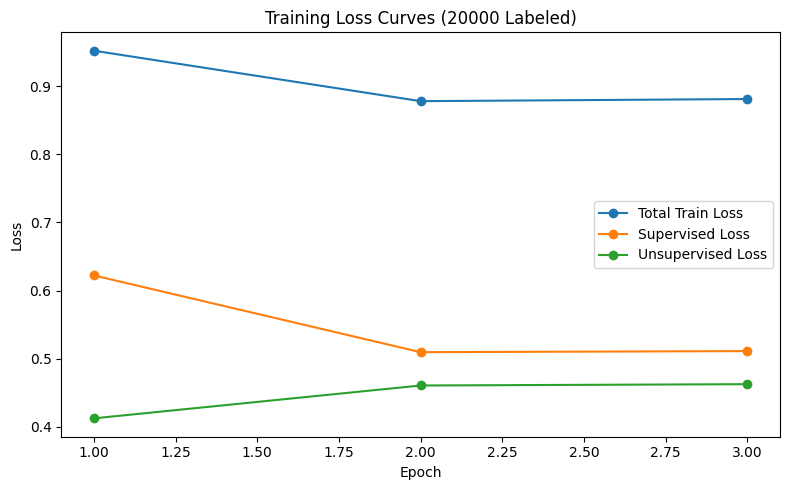

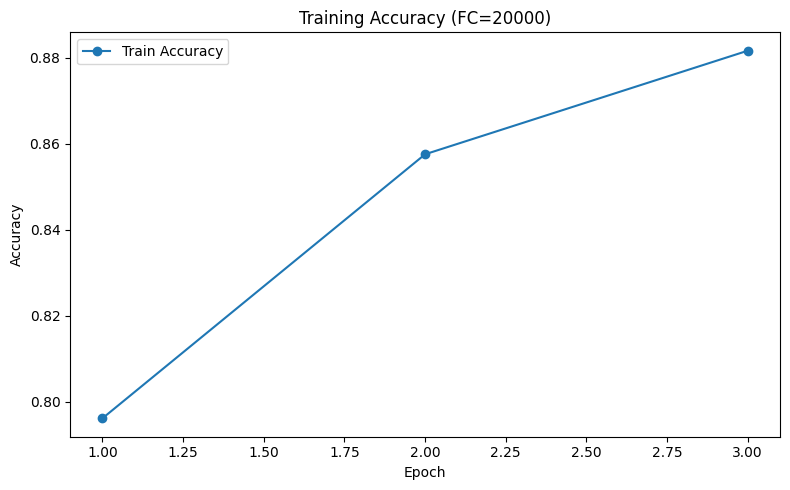

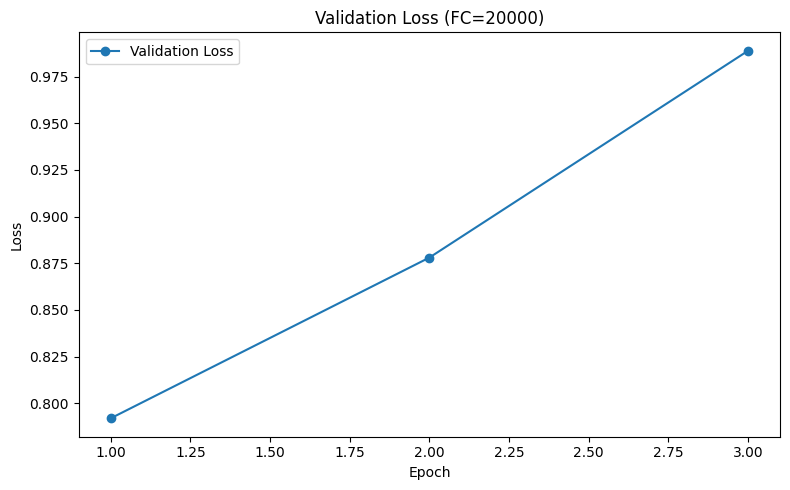

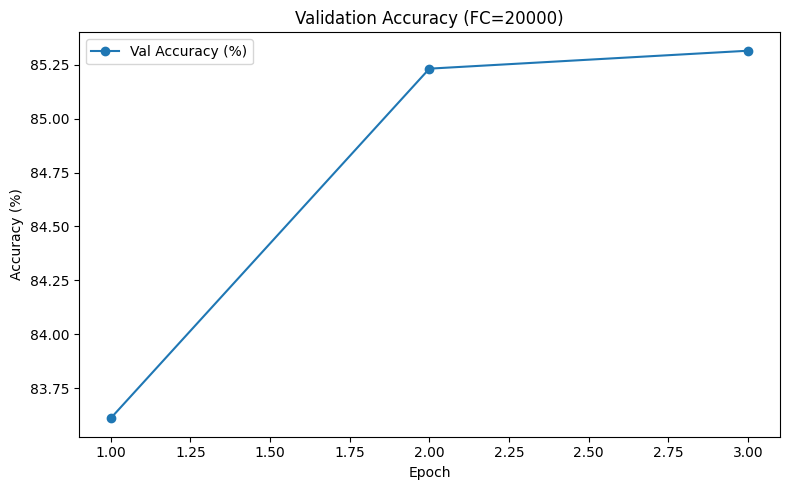

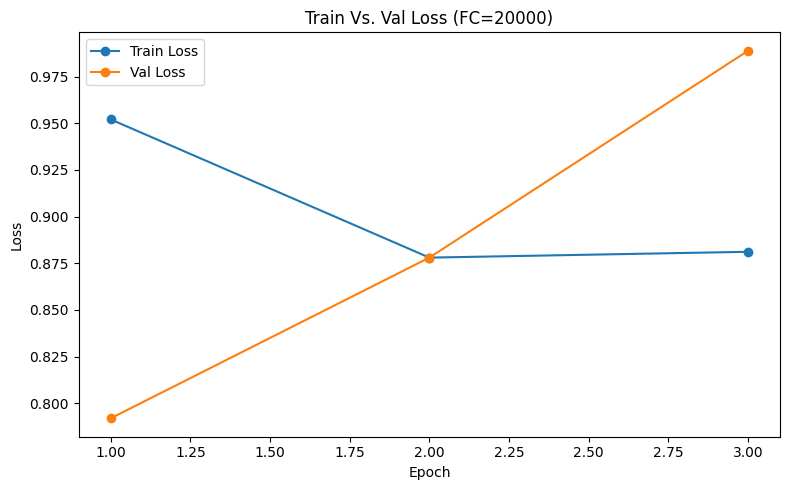

--- Finished Plotting For 20000 Labeled Samples ---

Running ReFixMatch With 40000 Labeled Samples Training Samples


PubMedRCT_40000_Labeled Epoch[1/3] TrainLoss: 0.9142 (Sup=0.5908, Unsup=0.4043) TrainAcc: 81.22% ValLoss: 0.8232 ValAcc: 84.58%


PubMedRCT_40000_Labeled Epoch[2/3] TrainLoss: 0.9377 (Sup=0.5780, Unsup=0.4496) TrainAcc: 86.16% ValLoss: 0.8662 ValAcc: 85.84%


PubMedRCT_40000_Labeled Epoch[3/3] TrainLoss: 0.9406 (Sup=0.5543, Unsup=0.4829) TrainAcc: 88.33% ValLoss: 1.0666 ValAcc: 86.09%

PubMedRCT_40000_Labeled Final Test Results:
Test Accuracy: 85.81%
ROC AUC: 0.9664, Average Precision: 0.8470
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.73      0.71      2879
 CONCLUSIONS       0.81      0.79      0.80      3632
     METHODS       0.92      0.95      0.93      7922
   OBJECTIVE       0.72      0.59      0.65      1855
     RESULTS       0.91      0.91      0.91      7751

    accuracy                           0.86     24039
   macro avg       0.81      0.79      0.80     24039
weighted avg       0.86      0.86      0.86     24039

Model weights saved to model_weights_40000_labeled.pt


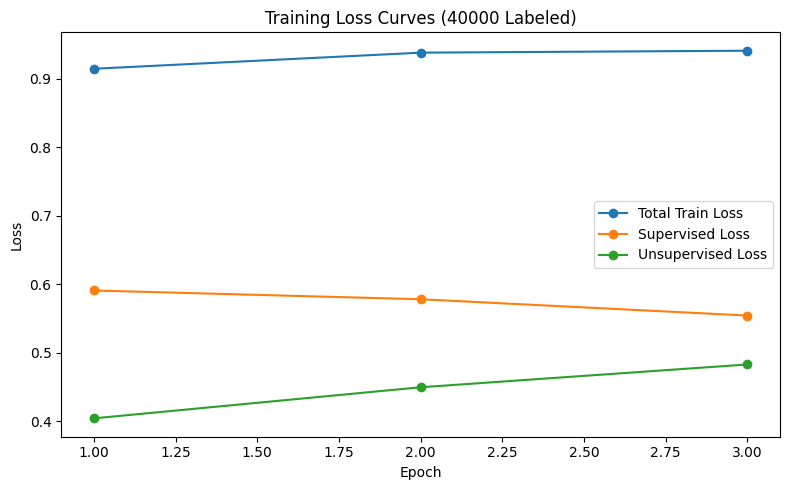

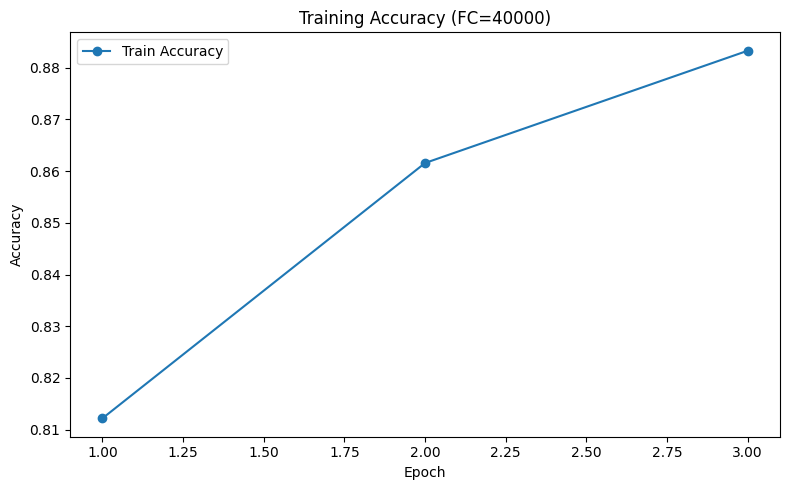

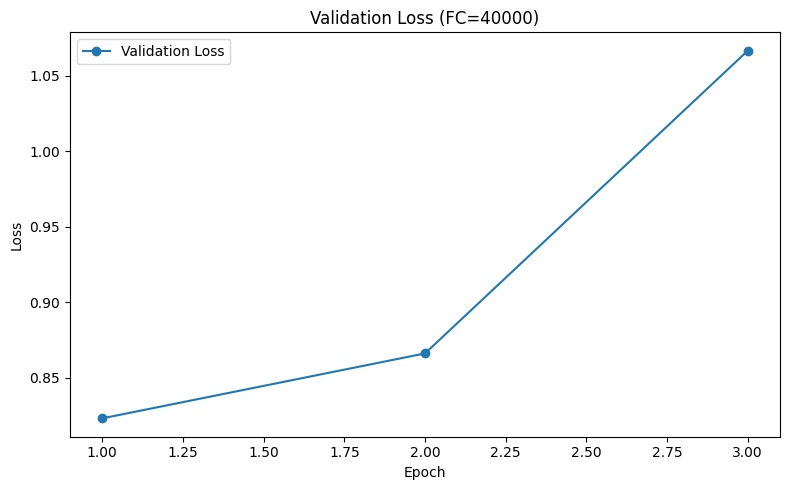

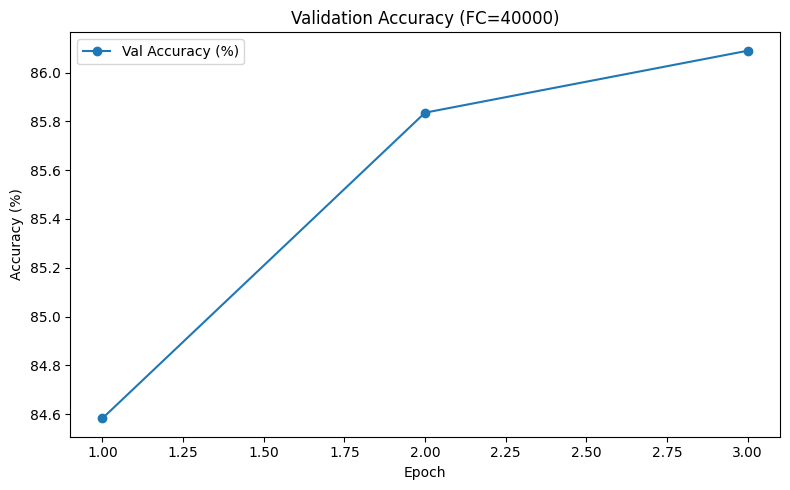

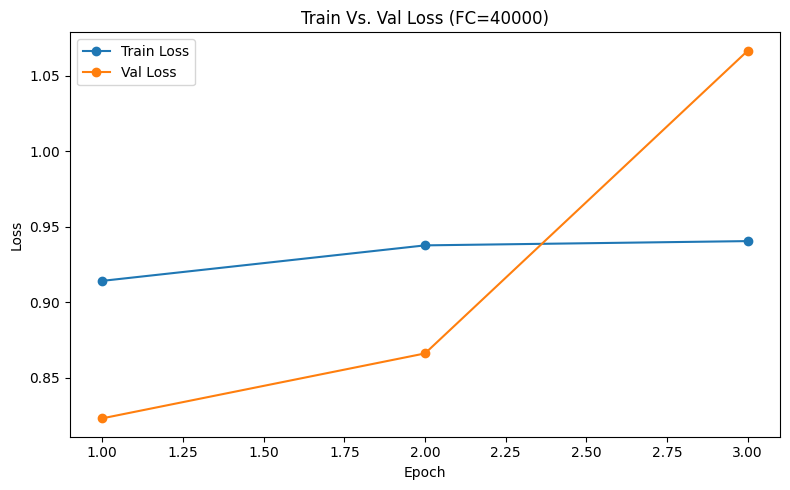

--- Finished Plotting For 40000 Labeled Samples ---

Running ReFixMatch With 80000 Labeled Samples Training Samples


PubMedRCT_80000_Labeled Epoch[1/3] TrainLoss: 0.9047 (Sup=0.5813, Unsup=0.4043) TrainAcc: 82.71% ValLoss: 0.8022 ValAcc: 85.70%


PubMedRCT_80000_Labeled Epoch[2/3] TrainLoss: 0.9492 (Sup=0.6036, Unsup=0.4319) TrainAcc: 86.55% ValLoss: 1.0886 ValAcc: 86.31%


PubMedRCT_80000_Labeled Epoch[3/3] TrainLoss: 0.9699 (Sup=0.6179, Unsup=0.4400) TrainAcc: 88.55% ValLoss: 1.1379 ValAcc: 86.69%

PubMedRCT_80000_Labeled Final Test Results:
Test Accuracy: 86.34%
ROC AUC: 0.9680, Average Precision: 0.8544
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.75      0.72      2879
 CONCLUSIONS       0.82      0.82      0.82      3632
     METHODS       0.93      0.95      0.94      7922
   OBJECTIVE       0.72      0.57      0.63      1855
     RESULTS       0.91      0.91      0.91      7751

    accuracy                           0.86     24039
   macro avg       0.81      0.80      0.80     24039
weighted avg       0.86      0.86      0.86     24039

Model weights saved to model_weights_80000_labeled.pt


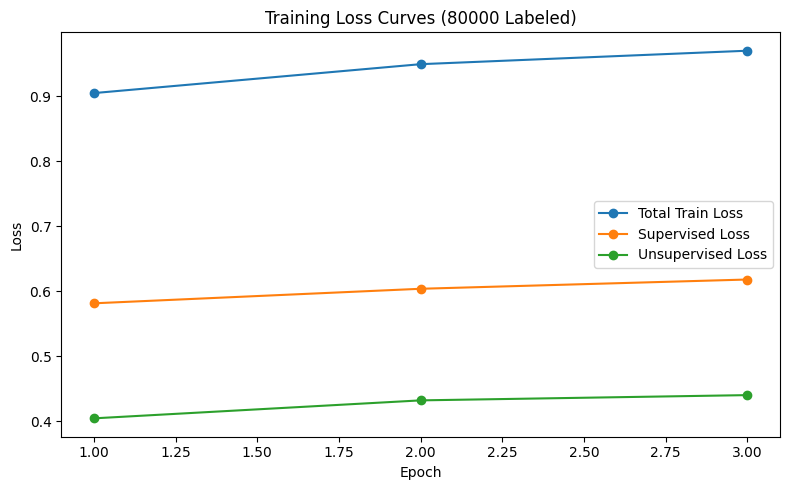

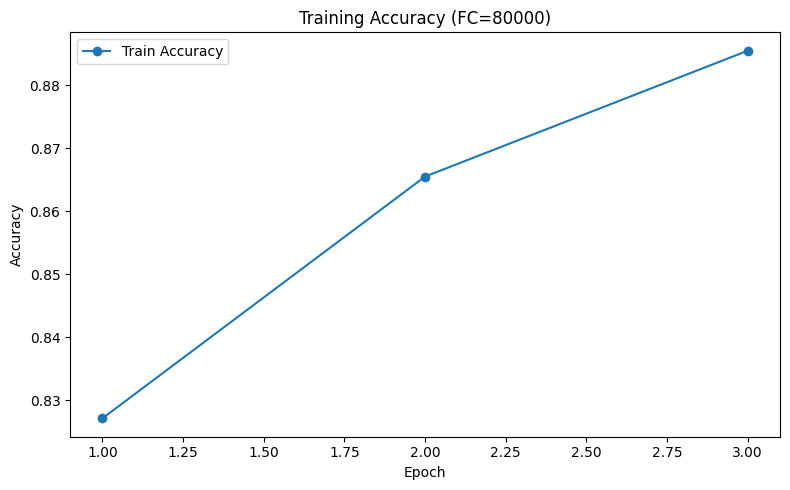

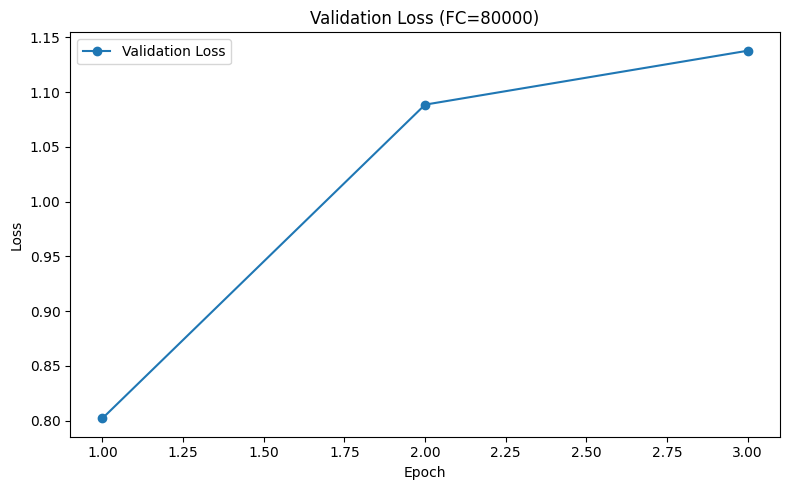

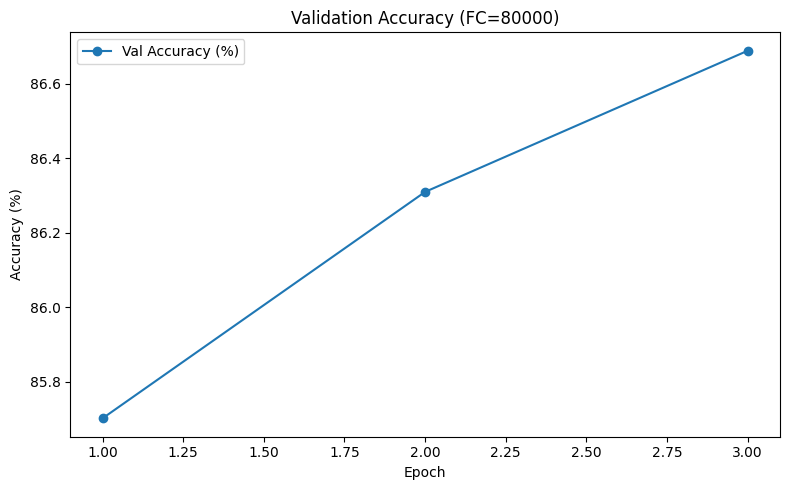

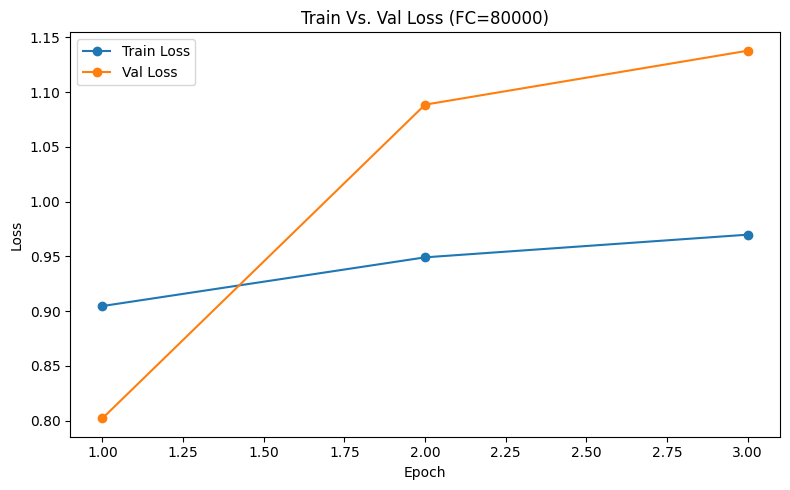

--- Finished Plotting For 80000 Labeled Samples ---

Running ReFixMatch With 120000 Labeled Samples Training Samples


PubMedRCT_120000_Labeled Epoch[1/3] TrainLoss: 0.9026 (Sup=0.5831, Unsup=0.3995) TrainAcc: 83.32% ValLoss: 0.9323 ValAcc: 85.95%


PubMedRCT_120000_Labeled Epoch[2/3] TrainLoss: 0.9590 (Sup=0.6335, Unsup=0.4069) TrainAcc: 86.74% ValLoss: 1.1630 ValAcc: 86.61%


PubMedRCT_120000_Labeled Epoch[3/3] TrainLoss: 0.9637 (Sup=0.6478, Unsup=0.3948) TrainAcc: 88.63% ValLoss: 1.1652 ValAcc: 86.85%

PubMedRCT_120000_Labeled Final Test Results:
Test Accuracy: 86.79%
ROC AUC: 0.9690, Average Precision: 0.8572
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.77      0.73      2879
 CONCLUSIONS       0.83      0.81      0.82      3632
     METHODS       0.93      0.95      0.94      7922
   OBJECTIVE       0.74      0.57      0.64      1855
     RESULTS       0.91      0.92      0.92      7751

    accuracy                           0.87     24039
   macro avg       0.82      0.80      0.81     24039
weighted avg       0.87      0.87      0.87     24039

Model weights saved to model_weights_120000_labeled.pt


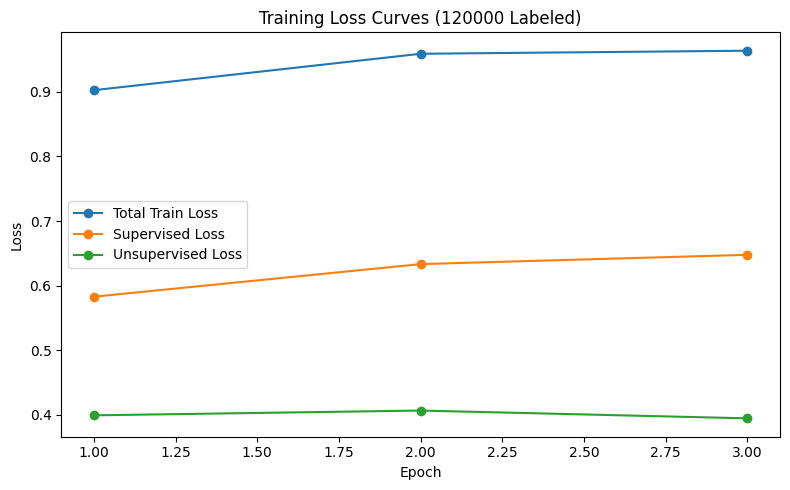

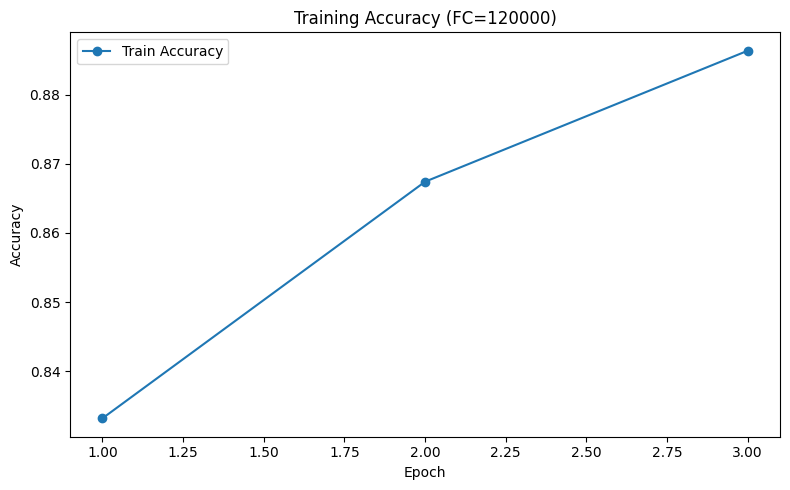

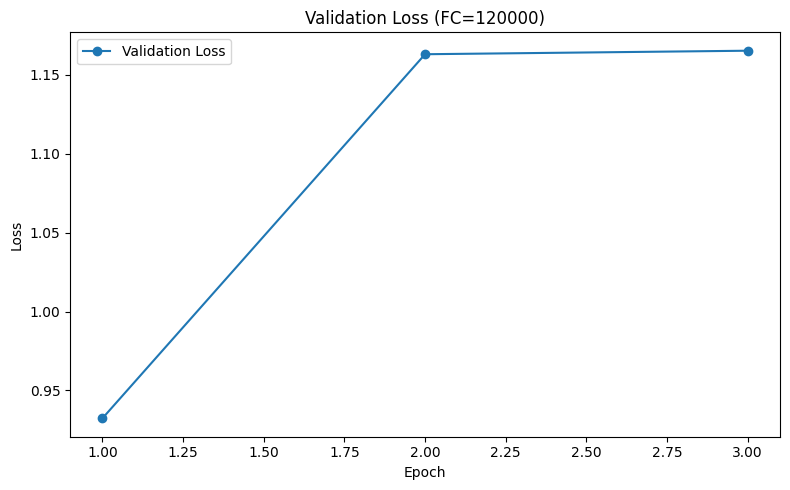

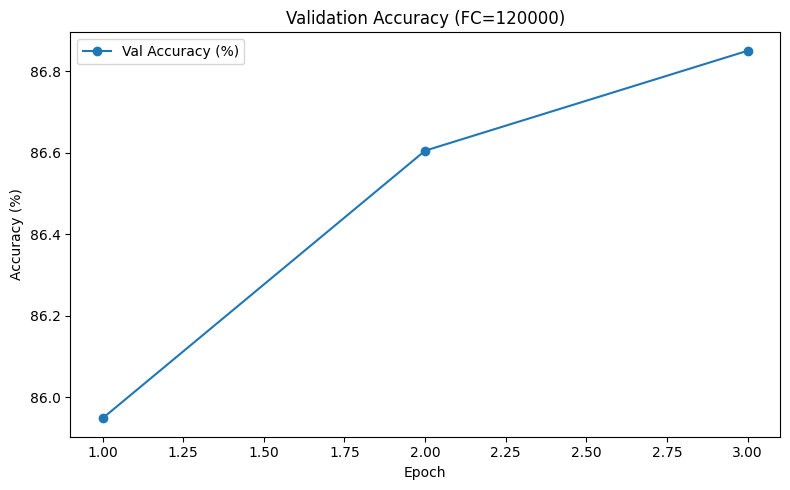

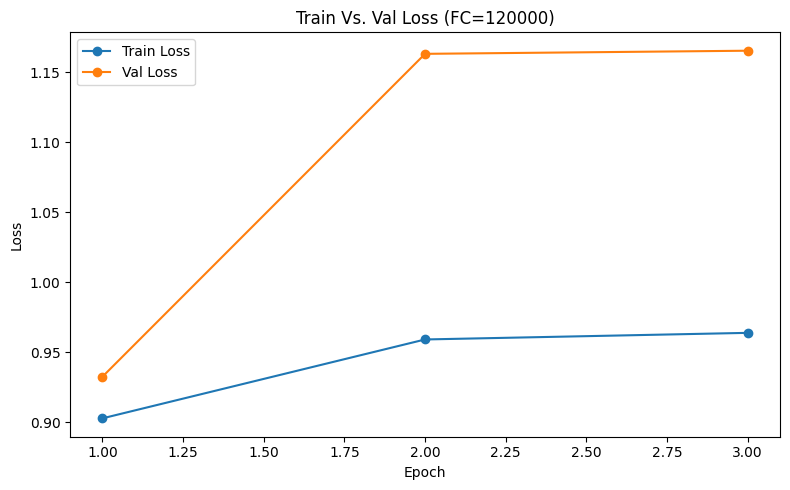

--- Finished Plotting For 120000 Labeled Samples ---

Best Run: 120000 Labeled Samples With Test Accuracy: 86.79%


In [ ]:
if __name__ == "__main__":
    from multiprocessing import freeze_support
    freeze_support()
    Main()